# 1. Library

In [1]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import cv2
import pandas as pd
from tqdm import tqdm
import os
import natsort
from glob import glob
import numpy as np
import warnings
import json
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 2. Data_Load

100%|████████████████████████████████████████████████████████████████████████████| 1684/1684 [00:01<00:00, 1255.87it/s]


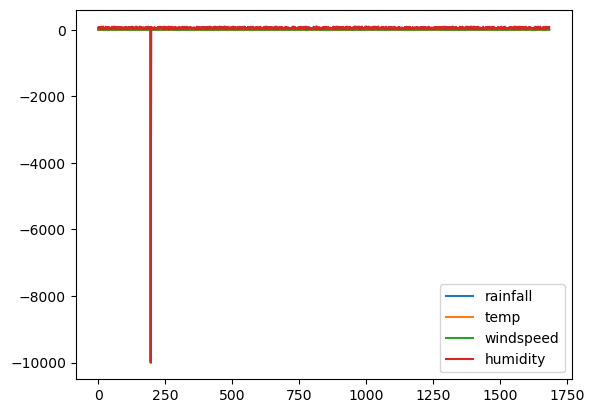

In [2]:
path=f"Modeling_data/train/"

height_train=np.load(path+'Height_train.npy')
ndvi_train=np.load(path+'NDVI_train.npy')
slope_train=np.load(path+'Slope_train.npy')
landuse_train=np.load(path+'Landuse_train.npy')
popden_train=np.load(path+'population_density_train.npy')

tabular_data=pd.read_csv(path+"climate_train.csv")
tabular_data.drop(['lon', 'lat'],axis=1,inplace=True)
tabular_data=tabular_data.replace(32767.0,-9999)
#tabular_data=tabular_data.replace(-9999.0,0)
tabular_data[['rainfall','temp','windspeed','humidity']].plot()
x,y=[],[]
for j in tqdm(range(len(tabular_data))):
    x.append(np.array(tabular_data.loc[j, ['humidity', 'rainfall', 'temp', 'windspeed']]).astype(float))
    y.append(np.array(tabular_data.loc[j, ['target']]).astype(float))
climate_train = np.array(x)
y = np.array(y)

In [3]:
# Validation data paths
val_path = "Modeling_data/val/"

height_val = np.load(val_path + 'Height_val.npy')
ndvi_val = np.load(val_path + 'NDVI_val.npy')
slope_val = np.load(val_path + 'Slope_val.npy')
landuse_val = np.load(val_path + 'Landuse_val.npy')
popden_val = np.load(val_path + 'population_density_val.npy')

# Load and preprocess tabular validation data
tabular_val = pd.read_csv(val_path + "climate_val.csv")
tabular_val.drop(['lon', 'lat'], axis=1, inplace=True)
tabular_val = tabular_val.replace(32767.0, -9999)

x_val, y_val = [], []
for j in tqdm(range(len(tabular_val))):
    x_val.append(np.array(tabular_val.loc[j, ['humidity', 'rainfall', 'temp', 'windspeed']]).astype(float))
    y_val.append(np.array(tabular_val.loc[j, ['target']]).astype(float))

climate_val = np.array(x_val)
y_val = np.array(y_val)

100%|██████████████████████████████████████████████████████████████████████████████| 422/422 [00:00<00:00, 1305.35it/s]


## 1) Make_model [WLH]

In [17]:
# Model Inputs
image_size = 24

height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
landuse_input = Input(shape=(image_size, image_size, 3), name='landuse_input')
popden_input = Input(shape=(image_size, image_size, 3), name='popden_input')
climate_input = Input(shape=(4, 1), name='climate_input')

# Training data
train = {
    'height_input': height_train,
    'ndvi_input': ndvi_train,
    'slope_input': slope_train,
    'landuse_input': landuse_train,
    'popden_input': popden_train,
    'climate_input': climate_train
}

# Validation data
val = {
    'height_input': height_val,
    'ndvi_input': ndvi_val,
    'slope_input': slope_val,
    'landuse_input': landuse_val,
    'popden_input': popden_val,
    'climate_input': climate_val
}

# CNN Layers with Dropout
def Cnn_layers(input_layer):
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    flatten = Flatten()(pool4)
    dropout = Dropout(0.5)(flatten)
    dense1 = Dense(128, activation='relu')(dropout)
    
    return dense1

# Dense Layer
def Dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2

# CNN Models for each feature
height_Cnn = Cnn_layers(height_input)
ndvi_Cnn = Cnn_layers(ndvi_input)
slope_Cnn = Cnn_layers(slope_input)
landuse_Cnn = Cnn_layers(landuse_input)
popden_Cnn = Cnn_layers(popden_input)
climate_MLP = Dense_layer(climate_input)

# Concatenate features and create output layer
merged = concatenate([height_Cnn, ndvi_Cnn, slope_Cnn, landuse_Cnn, popden_Cnn, climate_MLP])
output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

# Model compilation
model = Model(inputs=[height_input, ndvi_input, slope_input, landuse_input, popden_input, climate_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Reduce Learning Rate Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Model training with history
history = model.fit(train, y, validation_data=(val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid()
plt.ylim(0, 1)  # Fixing y-axis from 0 to 1 with 0.1 intervals
plt.yticks([i/10 for i in range(11)])

# Save the figure
loss_plot_path = "Model_loss/WLH_loss_plot.png"
plt.savefig(loss_plot_path, dpi=300)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

#Model save
model_save_path = "Model_save/WLH_model.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Epoch 1/50
27/27 [==============================] - 191s 7s/step - loss: 0.5178 - accuracy: 0.7375 - val_loss: 0.5264 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 2/50
27/27 [==============================] - 186s 7s/step - loss: 0.5130 - accuracy: 0.7429 - val_loss: 0.5287 - val_accuracy: 0.7227 - lr: 1.0000e-04
Epoch 3/50
27/27 [==============================] - 175s 6s/step - loss: 0.5138 - accuracy: 0.7435 - val_loss: 0.5286 - val_accuracy: 0.7180 - lr: 1.0000e-04
Epoch 4/50
27/27 [==============================] - 165s 6s/step - loss: 0.5152 - accuracy: 0.7405 - val_loss: 0.5260 - val_accuracy: 0.7346 - lr: 1.0000e-04
Epoch 5/50
27/27 [==============================] - 178s 7s/step - loss: 0.5117 - accuracy: 0.7411 - val_loss: 0.5277 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 6/50
27/27 [==============================] - 192s 7s/step - loss: 0.5120 - accuracy: 0.7399 - val_loss: 0.5246 - val_accuracy: 0.7464 - lr: 1.0000e-04
Epoch 7/50
27/27 [==============================] - 

## 2) Make_Model [WL]

In [6]:
# Model Inputs
image_size = 24

height_input = Input(shape=(image_size, image_size, 3), name='height_input')
ndvi_input = Input(shape=(image_size, image_size, 3), name='ndvi_input')
slope_input = Input(shape=(image_size, image_size, 3), name='slope_input')
climate_input = Input(shape=(4, 1), name='climate_input')

# Modified CNN Layers with Dropout
def Cnn_layers(input_layer):
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    flatten = Flatten()(pool4)
    dropout = Dropout(0.5)(flatten)
    dense1 = Dense(128, activation='relu')(dropout)
    
    return dense1

# Dense Layer
def Dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2

# CNN Models for each feature
height_Cnn = Cnn_layers(height_input)
ndvi_Cnn = Cnn_layers(ndvi_input)
slope_Cnn = Cnn_layers(slope_input)
climate_MLP = Dense_layer(climate_input)

# Concatenate features and create output layer
merged = concatenate([height_Cnn, ndvi_Cnn, slope_Cnn, climate_MLP])
output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

# Model compilation
model = Model(inputs=[height_input, ndvi_input, slope_input, climate_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training data
train = {
    'height_input': height_train,
    'ndvi_input': ndvi_train,
    'slope_input': slope_train,
    'climate_input': climate_train
}

# Validation data
val = {
    'height_input': height_val,
    'ndvi_input': ndvi_val,
    'slope_input': slope_val,
    'climate_input': climate_val
}

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Reduce Learning Rate Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Model training with history
history = model.fit(train, y, validation_data=(val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid()
plt.ylim(0, 1)  # Fixing y-axis from 0 to 1 with 0.1 intervals
plt.yticks([i/10 for i in range(11)])

# Save the figure
loss_plot_path = "Model_loss/WL_loss_plot.png"
plt.savefig(loss_plot_path, dpi=300)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

#Model save
model_save_path = "Model_save/WL_model.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Epoch 1/50
27/27 [==============================] - 92s 3s/step - loss: 0.9215 - accuracy: 0.6093 - val_loss: 0.6244 - val_accuracy: 0.6564 - lr: 1.0000e-04
Epoch 2/50
27/27 [==============================] - 99s 4s/step - loss: 0.7620 - accuracy: 0.6971 - val_loss: 0.5702 - val_accuracy: 0.7370 - lr: 1.0000e-04
Epoch 3/50
27/27 [==============================] - 98s 4s/step - loss: 0.6255 - accuracy: 0.7399 - val_loss: 0.5377 - val_accuracy: 0.7085 - lr: 1.0000e-04
Epoch 4/50
27/27 [==============================] - 95s 4s/step - loss: 0.5308 - accuracy: 0.7435 - val_loss: 0.5350 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 5/50
27/27 [==============================] - 97s 4s/step - loss: 0.5428 - accuracy: 0.7322 - val_loss: 0.5321 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 6/50
27/27 [==============================] - 96s 4s/step - loss: 0.5243 - accuracy: 0.7369 - val_loss: 0.5315 - val_accuracy: 0.7156 - lr: 1.0000e-04
Epoch 7/50
27/27 [==============================] - 96s 4s

## 3) Make_Model [W]

In [15]:
# Model Inputs
image_size = 24

climate_input = Input(shape=(4, 1), name='climate_input')

# Modified CNN Layers with Dropout
def Cnn_layers(input_layer):
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    flatten = Flatten()(pool4)
    dropout = Dropout(0.5)(flatten)
    dense1 = Dense(128, activation='relu')(dropout)
    
    return dense1

# Dense Layer
def Dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2

# CNN Models for each feature
climate_MLP = Dense_layer(climate_input)

# Concatenate features and create output layer
merged = concatenate([climate_MLP])
output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

# Model compilation
model = Model(inputs=[climate_input], outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training data
train = {
    'climate_input': climate_train
}

# Validation data
val = {
    'climate_input': climate_val
}

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Reduce Learning Rate Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Model training with history
history = model.fit(train, y, validation_data=(val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)  # Fixing y-axis from 0 to 1 with 0.1 intervals
plt.yticks([i/10 for i in range(16)])

# Save the figure
loss_plot_path = "Model_loss/W_loss_plot.png"
plt.savefig(loss_plot_path, dpi=300)
plt.close()

print(f"Loss plot saved to: {loss_plot_path}")

#Model save
model_save_path = "Model_save/W_model.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Epoch 1/50
27/27 [==============================] - 1s 10ms/step - loss: 1.0619 - accuracy: 0.5713 - val_loss: 0.6335 - val_accuracy: 0.6374 - lr: 1.0000e-04
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6746 - val_loss: 0.6091 - val_accuracy: 0.6777 - lr: 1.0000e-04
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5917 - accuracy: 0.6900 - val_loss: 0.6088 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.6847 - val_loss: 0.6079 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5880 - accuracy: 0.6906 - val_loss: 0.6069 - val_accuracy: 0.6706 - lr: 1.0000e-04
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 0.5865 - accuracy: 0.6847 - val_loss: 0.6040 - val_accuracy: 0.6706 - lr: 1.0000e-04
Epoch 7/50
27/27 [==============================] - 0s 3m

Loss plot saved to: Revision_data/data_set(nofire)/Model_save/W_loss_plot.png
